In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matryoshka.rsd as MatRSD
import matryoshka.eft_funcs as MatEFT
import matryoshka.halo_model_funcs as MatHM
import matryoshka.emulator as MatEmu
from scipy.interpolate import interp1d

In [2]:
def C00_gauss(k, Pk, f, b, ng, deltak, Vs):
    beta = f/b
    Nk = (4*np.pi*k**2*deltak)/(2*np.pi/Vs**(1/3))**3
    A = (1 + 4/3*f + 6/5*beta**2 + 4/7*beta**3 + 1/9*beta**4)*(b**2*Pk)**2
    B = 2/ng*(1 + 2/3*beta + 1/5*beta**2)*b**2*Pk
    return 2/Nk*(A+B+1/ng**2)

def C02_gauss(k, Pk, f, b, ng, deltak, Vs):
    beta = f/b
    Nk = (4*np.pi*k**2*deltak)/(2*np.pi/Vs**(1/3))**3
    A = (8/3*beta + 24/7*beta**2 + 40/21*beta**3 + 40/99*beta**4)*(b**2*Pk)**2
    B = 2/ng*(4/3*beta + 4/7*beta**2)*b**2*Pk
    return 2/Nk*(A+B)

def C22_gauss(k, Pk, f, b, ng, deltak, Vs):
    beta = f/b
    Nk = (4*np.pi*k**2*deltak)/(2*np.pi/Vs**(1/3))**3
    A = (5 + 220/21*beta + 90/7*beta**2 + 1700/231*beta**3 + 2075/1287*beta**4)*(b**2*Pk)**2
    B = 2/ng*(5 + 110/21*beta + 15/7*beta**2)*b**2*Pk
    return 2/Nk*(A+B+5/ng**2)

In [8]:
redshift = 0.61

fid_bs = np.array([2., 1., 0.5, 0., 0.5, 2., 0.])
fid_cosmo = np.array([0.11933, 0.02242, 0.6766, 3.047, 0.9665])
fid_fb = (fid_cosmo[1]/fid_cosmo[2]**2)/(fid_cosmo[0]/fid_cosmo[2]**2+fid_cosmo[1]/fid_cosmo[2]**2)
fid_stoch = np.array([0., 0., -2.5])
Om_AP_fid = 0.3
ng = 3e-4

path_to_eft_data = "/Users/jamie/Desktop/EFTicg/P18/"

P110_P18 = np.load(path_to_eft_data+"P110-z{a}_P18_optiresum-True.npy".format(a=redshift))
Ploop0_P18 = np.load(path_to_eft_data+"Ploop0-z{a}_P18_optiresum-True.npy".format(a=redshift))
Pct0_P18 = np.load(path_to_eft_data+"Pct0-z{a}_P18_optiresum-True.npy".format(a=redshift))
P112_P18 = np.load(path_to_eft_data+"P112-z{a}_P18_optiresum-True.npy".format(a=redshift))
Ploop2_P18 = np.load(path_to_eft_data+"Ploop2-z{a}_P18_optiresum-True.npy".format(a=redshift))
Pct2_P18 = np.load(path_to_eft_data+"Pct2-z{a}_P18_optiresum-True.npy".format(a=redshift))

f = MatHM.fN((fid_cosmo[0]+fid_cosmo[1])/fid_cosmo[2]**2, redshift)
P0_fid_noAP = MatEFT.multipole([P110_P18,Ploop0_P18,Pct0_P18],fid_bs,f,stochastic=fid_stoch, ng=ng, multipole=0, 
                          kbins=MatEmu.kbird)[:39]
P2_fid_noAP = MatEFT.multipole([P112_P18,Ploop2_P18,Pct2_P18],fid_bs,f,stochastic=fid_stoch, ng=ng, multipole=2, 
                          kbins=MatEmu.kbird)[:39]

In [9]:
klin = np.linspace(MatEmu.kbird[:39].min(), MatEmu.kbird[:39].max(), MatEmu.kbird[:39].shape[0])

In [10]:
P0_int = interp1d(MatEmu.kbird[:39], P0_fid_noAP)(klin)
P2_int = interp1d(MatEmu.kbird[:39], P2_fid_noAP)(klin)

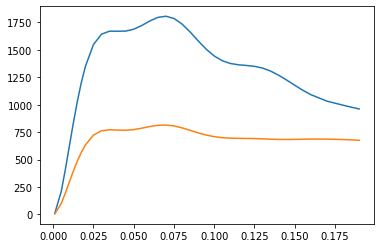

In [11]:
plt.plot(MatEmu.kbird[:39], MatEmu.kbird[:39]*P0_fid_noAP)
plt.plot(MatEmu.kbird[:39], MatEmu.kbird[:39]*P2_fid_noAP)

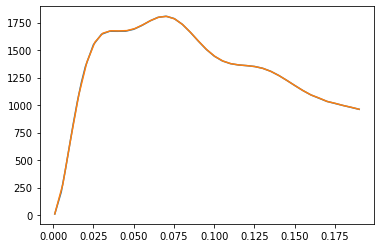

In [12]:
plt.plot(MatEmu.kbird[:39], MatEmu.kbird[:39]*P0_fid_noAP)
plt.plot(klin, klin*P0_int)

In [13]:
kk = np.load(path_to_eft_data+"Plin-z{a}_P18.npy".format(a=redshift))[0]
Plin = np.load(path_to_eft_data+"Plin-z{a}_P18.npy".format(a=redshift))[1]

In [15]:
Plin_int = interp1d(kk, Plin)(klin)

In [25]:
C00 = C00_gauss(klin, Plin_int, f, fid_bs[0], ng, np.diff(klin)[0], 2000**3)
C22 = C22_gauss(klin, Plin_int, f, fid_bs[0], ng, np.diff(klin)[0], 2000**3)
C02 = C02_gauss(klin, Plin_int, f, fid_bs[0], ng, np.diff(klin)[0], 2000**3)

<ErrorbarContainer object of 3 artists>

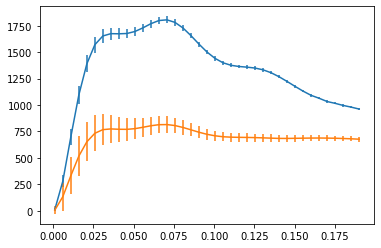

In [24]:
plt.errorbar(klin, klin*P0_int, yerr=np.sqrt(C00)*klin)
plt.errorbar(klin, klin*P2_int, yerr=np.sqrt(C22)*klin)

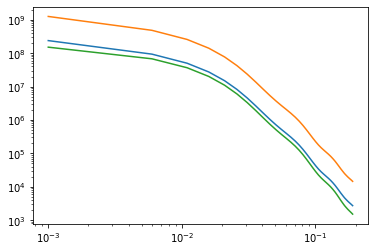

In [26]:
plt.loglog(klin, C00)
plt.loglog(klin, C22)
plt.loglog(klin, C02)
plt.show()

In [27]:
def make_cov(C00, C22, C02):
    '''
    Function to make full covariance matrix from the diagonal terms provided.
    
    Args:
        C00 (array) : Array containing the C_{00} diagonal terms. Should have shape ``(nk, )``.
        C22 (array) : Array containing the C_{22} diagonal terms. Should have shape ``(nk, )``.
        C02 (array) : Array containing the C_{02} diagonal terms. Should have shape ``(nk, )``.

    Returns:
        The full covariance matrix with shape ``(nk, nk)``.
    '''
    C00 = np.diag(C00)
    C22 = np.diag(C22)
    C02 = np.diag(C02)
    
    C = np.vstack([np.hstack([C00, C02]), np.hstack([C02, C22])])
    
    return C

In [29]:
matrix = make_cov(C00, C22, C02)

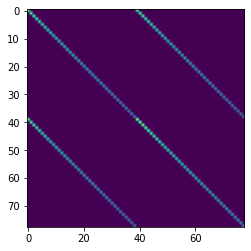

In [30]:
plt.imshow(np.log(matrix+1))

In [31]:
np.linalg.eigvals(matrix)

array([2.15789881e+08, 1.27850353e+09, 4.37167048e+07, 2.63756928e+08,
       7.89744680e+07, 1.30878504e+07, 7.18289375e+06, 4.33302420e+07,
       2.30257171e+06, 1.38761122e+07, 6.26439282e+05, 3.76850013e+06,
       3.47596437e+05, 2.08922314e+06, 2.06225969e+05, 1.23832845e+06,
       1.17574626e+05, 7.04900511e+05, 6.51149971e+04, 3.89469896e+05,
       3.81402704e+04, 2.27505509e+05, 2.52484474e+04, 1.50263576e+05,
       1.85748317e+04, 1.10373933e+05, 1.39167635e+04, 8.25577682e+04,
       1.00475362e+04, 5.94517319e+04, 8.39744501e+03, 4.96008482e+04,
       5.01706745e+03, 2.94556056e+04, 3.81150669e+03, 2.22995343e+04,
       3.06909450e+03, 1.79097313e+04, 2.52835091e+03, 1.47199211e+04,
       4.94068452e+08, 8.19865105e+07, 1.44115597e+08, 2.38810351e+07,
       1.39733021e+06, 8.41560934e+06, 9.05115118e+05, 5.44787843e+06,
       2.41100959e+07, 3.99853755e+06, 2.75225210e+06, 4.57720246e+05,
       1.61009606e+06, 2.67997293e+05, 1.56786633e+05, 9.40816407e+05,
      